# Markov Decision Processes

This is meant to be a tutorial guide through the structure of a Markov Decision Process (MDP), computing state and action values within a MDP and dealing with partial observability. This is work in progress but will hopefully be finished soon :)

In [20]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 1) MDP Structure

A Markov Decision Process (MDP) is based on a **state space**, **action space**, and a **reward function**. Let's go through this via an example called *gridworld* (see Sutton and Barto 2018, p. 60 and following)

### 1.1) State Space

The environment is a simple 5x5 grid where every cell reflects an individual **state of the environment**:

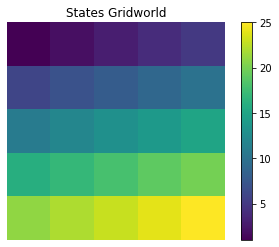

In [21]:
states = np.linspace(1,25,25).reshape(5,5)
#print(states)

plt.imshow(states, cmap='viridis')
plt.colorbar()
plt.axis('off')
plt.title('States Gridworld')
plt.show()

### 1.2) Action Space

An agent can move across this gridworld to collect rewards. There are four **actions**: move North, East, South or West

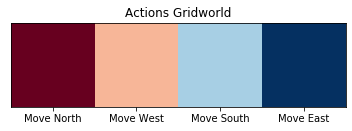

In [35]:
actions = np.linspace(1,4,4).reshape(1,4)
#rint(actions)

plt.imshow(actions, cmap='RdBu')
plt.yticks([])
plt.xticks(np.arange(4), ['Move North', 'Move West', 'Move South','Move East'])
plt.title('Actions Gridworld')
plt.show()

### 1.3) Rewards

Finally, we need to define the **rewards**. Let's assume that 
- Any action that would take the agent off the gridworld results in a reward of -1 and does not change the location of the agent
- Any movement from A (dark yellow below) results in a reward of +10 and moves the agent to A' (bright yellow below)
- Any movement from B (dark green below) results in a reward of +5 and moves the agent to B' (bright green below)
- All other actions result in a reward of 0

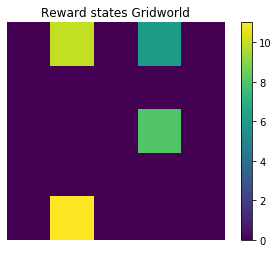

In [23]:
reward_map = np.zeros((5,5))
reward_map[0,1] = 10
reward_map[4,1] = 11
reward_map[0,3] = 6
reward_map[2,3] = 8
                      
plt.imshow(reward_map, cmap='viridis')
plt.colorbar()
plt.axis('off')
plt.title('Reward states Gridworld')
plt.show()

### 1.4) Dynamics

We can now specify the **dynamics** of the MDP. Those dynamics are defined in the following function $p$:

$$p(s',r|s,a) \overset{def}{=} Pr(S_t=s',R_t=r|S_{t-1}=s, A_{t-1}=a)$$


for all $s', s \in S$, $r \in R$, and $a \in A(s)$. This is a deterministic function with four arguments: a previous state $s$, an action $a$ at that previous state, a current state $s'$, and a reward $r$ at that current state.

$p$ is a probability function, such that $$\sum_{s' \in S} \sum_{r \in R}p(s', r|s, a)=1, \forall s \in S, a \in A(s)$$

This is really a crucial definition, because a lot of other notions follow from these dynamics:

The **state transition probabilities** are $$p(s'|s, a) \overset{def}{=}\sum_{r \in R}p(s', r|s, a)$$

The **expected rewards for state-action pairs** are $$r(s,a)\overset{def}{=}\sum_{r \in R}r\sum_{s' \in S}p(s', r|s, a)$$

The **expected rewards for state-action-state triples** are $$r(s,a,s')\overset{def}{=}\sum_{r \in R}r \frac{p(s', r|s, a)}{p(s'|s, a)}$$

Now let's define the dynamics:

In [84]:
# obtain p - not in the most elegant but hopefully more readable way
n_actions = 4 # move North, West, South or East
n_states = 25 # cells in gridworld
n_rewards = 4 # {-1, 0, 5, 10}
p = np.zeros((n_states,n_rewards,n_states,n_actions))

location_A  = [0,1]
location_Ap = [4,1]
location_B  = [0,3]
location_Bp = [2,3]

for a in range(n_actions):
    for s in range(n_states):
        idx = np.unravel_index(s, states.shape, order='F') # find where state is on 5x5 grid
        # now check if agent wants to move over borders:
        if (idx[0]==0 and a==0) or (idx[1]==states.shape[1]-1 and a==1) or (idx[0]==states.shape[0]-1 and a==2) or (idx[1]==0 and a==3):
            p[s,0,s,a] = 1 # agent will stay where it is and receive a negative reward
        elif idx[0]==location_B[0] & idx[1]==location_B[1]:
            p[np.ravel_multi_index(location_Bp, states.shape, order='F'),2,s,a] = 1 # agent will move to B' and receive a reward of 5
        elif idx[0]==location_A[0] & idx[1]==location_A[1]:
            p[np.ravel_multi_index(location_Ap, states.shape, order='F'),3,s,a] = 1 # agent will move to A' and receive a reward of 10
        else:
            if a == 0:
                p[np.ravel_multi_index([idx[0]-1,idx[1]], states.shape, order='F'),1,s,a] = 1 # Agent moves North by one field
            elif a == 1:
                p[np.ravel_multi_index([idx[0],idx[1]+1], states.shape, order='F'),1,s,a] = 1 # Agent moves West by one field
            elif a == 2:
                p[np.ravel_multi_index([idx[0]+1,idx[1]], states.shape, order='F'),1,s,a] = 1 # Agent moves South by one field
            elif a == 3:
                p[np.ravel_multi_index([idx[0],idx[1]-1], states.shape, order='F'),1,s,a] = 1 # Agent moves East by one field